# Neural Network Pytorch MLP

Vogliamo modellare un multi-layer perceptron utilizzando **Pytorch** per classificare il dataset MNIST.

In [142]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)

Using PyTorch version: 0.4.1.post2 CUDA: False


## Dati
Vogliamo utilizzare il dataset MNIST, si può scaricare direttamente o caricarlo dai documenti.

In [143]:
batch_size = 32

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=False, **kwargs)


Vogliamo ora estrarre le prime tre classi in modo da fare il train solo su queste.

Inoltre dividiamo il dataset così creato in train (80%) e validate (20%)

In [144]:
split = int(np.floor(len(train_loader.dataset.train_labels))*0.8)

train_l = train_loader.dataset.train_labels[0:split]
train_d = train_loader.dataset.train_data[0:split]

val_l = train_loader.dataset.train_labels[split:-1]
val_d = train_loader.dataset.train_data[split:-1]



In [145]:
zeros = train_d[train_l == 0]
ones = train_d[train_l == 1]
twos = train_d[train_l == 2]


train_data012 = torch.cat([zeros, ones, twos])
train_labels012 = torch.cat([torch.zeros((len(zeros),)), torch.ones((len(ones),)), 2.0*torch.ones((len(twos),))])

# ADB: Qui ho notato che c'e' un problema: le immagini sono int8, ma devono essere float32.
# Faccio la conversione e divido per 255.0 (cosi' i pixel sono fra 0.0 e 1.0).
train_data012 = train_data012.type(torch.float32) / 255.0

print(len(train_data012))

14961


In [146]:
zeros = val_d[val_l == 0]
ones = val_d[val_l == 1]
twos = val_d[val_l == 2]


val_data012 = torch.cat([zeros, ones, twos])
val_labels012 = torch.cat([torch.zeros((len(zeros),)), torch.ones((len(ones),)), 2.0*torch.ones((len(twos),))])

# ADB: Qui ho notato che c'e' un problema: le immagini sono int8, ma devono essere float32.
# Faccio la conversione e divido per 255.0 (cosi' i pixel sono fra 0.0 e 1.0).
val_data012 = val_data012.type(torch.float32) / 255.0

print(len(val_data012))

3662


Adesso creiamo dei nuovi dataset per il train in modo da vedere come reagisce il classificatore con dati ID e OOD:

In [147]:
test_l012 = test_loader.dataset.test_labels
test_d012 = test_loader.dataset.test_data

zeros = test_d012[test_l012 == 0]
ones = test_d012[test_l012 == 1]
twos = test_d012[test_l012 == 2]


test_data012 = torch.cat([zeros, ones, twos])
test_labels012 = torch.cat([torch.zeros((len(zeros),)), torch.ones((len(ones),)), 2.0*torch.ones((len(twos),))])

# ADB: Qui ho notato che c'e' un problema: le immagini sono int8, ma devono essere float32.
# Faccio la conversione e divido per 255.0 (cosi' i pixel sono fra 0.0 e 1.0).
test_data012 = test_data012.type(torch.float32) / 255.0


In [148]:
test_l = test_loader.dataset.test_labels
test_d = test_loader.dataset.test_data

threes = test_d[test_l == 3]
fours = test_d[test_l == 4]
fives = test_d[test_l == 5]

test_data345 = torch.cat([threes, fours, fives])

# ADB: Qui ho notato che c'e' un problema: le immagini sono int8, ma devono essere float32.
# Faccio la conversione e divido per 255.0 (cosi' i pixel sono fra 0.0 e 1.0).
test_data345 = test_data345.type(torch.float32) / 255.0

print(test_data345.type())

torch.FloatTensor


Adesso possiamo utilizzare i nuovi dataset creati per train, validation e test.

In [149]:
from torch.utils.data import TensorDataset

# Train012 80%
train_ds012 = TensorDataset(train_data012, train_labels012)
train_loader012 = torch.utils.data.DataLoader(train_ds012, batch_size=batch_size, shuffle=True, **kwargs)
print(len(train_loader012))

# Validation012 20%
validation_ds012 = TensorDataset(val_data012, val_labels012)
validation_loader012 = torch.utils.data.DataLoader(validation_ds012, batch_size=batch_size, shuffle=True, **kwargs)
print(len(validation_loader012))

# Test012 all
test_ds012 = TensorDataset(test_data012, test_labels012)
test_loader012 = torch.utils.data.DataLoader(test_ds012, batch_size=batch_size, shuffle=True, **kwargs)
print(len(test_loader012))

# Test345 all
test_loader345 = torch.utils.data.DataLoader(test_data345, batch_size=batch_size, shuffle=True, **kwargs)
print(len(test_loader345))

468
115
99
91


## ADB: Osservazioni
Stiamo mischiando un po' i concetti di 'train', 'test' e 'validate'. Per noi, servono:

- Dati IN DISTRIBUTION per training (il train_loader012 va bene per questo). 
- Dati IN DISTRIBUTION per validation (i.e. per monitorare quanto bene classifichiamo le classi IN DISTRIBUTION). NON abbiamo questi data per la validation per ora.  
- Dati OUT OF DISTRIBUTION (OOD) per i test finali (questo abbiamo, ma abbiamo chiamato 'validation'). Non possiamo usare questi dati nella funzione validate() sotto, per esempio, perche' non abbiamo ettichette e perche' non sono IN DISTRIBUTION. 


Riassumendo: bisogna anche estrarre/filtrare immagini e ettichette da validation_loader con le ettichette [0, 1, 2] per usare come validation.

## Prove

1) Proviamo a stampare le prime 10 immagini del train:

In [150]:
# ADB: qui ho modificato perche' ora ogni batch contiene un gruppo di immagini e anche un gruppo di label.
for (X_train, y_train) in train_loader012:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.FloatTensor


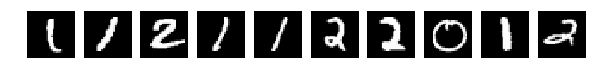

In [151]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :].numpy().reshape(28,28), cmap="gray")

2) Proviamo a stampare le prime 10 immagini del validation:

In [152]:
for (V_train, y_train) in validation_loader012:
    print('V_train:', V_train.size(), 'type:', V_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

V_train: torch.Size([32, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.FloatTensor


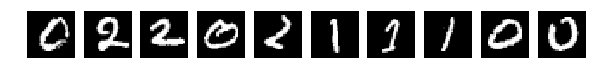

In [153]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(V_train[i, :, :].numpy().reshape(28,28), cmap="gray")

3) Proviamo a stampare le prime 10 immagini del test:

In [154]:
for (T_train, y_train) in test_loader012:
    print('T_train:', T_train.size(), 'type:', T_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

T_train: torch.Size([32, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.FloatTensor


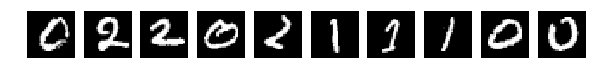

In [155]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(V_train[i, :, :].numpy().reshape(28,28), cmap="gray")

In [156]:
for Y_train in test_loader345:
    print('Y_train:', Y_train.size(), 'type:', Y_train.type())
    break

Y_train: torch.Size([32, 28, 28]) type: torch.FloatTensor


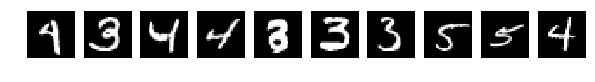

In [157]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(Y_train[i, :, :].numpy().reshape(28,28), cmap="gray")

## Multi-layer Perceptron
Definiamo ora la rete neurale come una Python class.

In [158]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 128)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 3)     # Numero di output 3.

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), 1)

model = Net()
if cuda:
    model.cuda()
    
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc1_drop): Dropout(p=0.2)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc2_drop): Dropout(p=0.2)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)


Definiamo le funzioni di **train** e **test**

In [159]:
def train(epoch, log_interval=100):
    model.train()
    batch_idx = 0
    while(batch_idx != len(train_loader012)):
        for (data, target) in train_loader012:
            target = target.type(torch.long)
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader012.dataset),
                    100. * batch_idx / len(train_loader012), loss.item()))
            batch_idx = batch_idx + 1

In [160]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader012:
        target = target.type(torch.long)
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        val_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader012)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader012.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader012.dataset), accuracy))

In [161]:
def test(epoch):
    model.eval ()
    test_loss = 0
    correct = 0
    for data, target in test_loader012:
        target = target.type(torch.long)
        if cuda:
            data, target = data.cuda(), target.cuda()
        data = Variable(data)
        target = Variable(target)
        output = model (data)
        test_loss += F.nll_loss (output, target).item ()  # sum up batch loss
        pred = output.max (1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq (target.view_as (pred)).sum ().item ()
    test_loss /= len (test_loader012.dataset)
    print ('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format (
        test_loss, correct, len (test_loader012.dataset),
        100. * correct / len (test_loader012.dataset)))

In [165]:
#-------------------------------PROBLEMA--------------------------
# Siccome test_loader012 ha due campi prende data come una lista e non come un tensore,
#probabilmentee nella funzione bisogna estrarre solo il primo campo data e il target toglierlo che ci sia o no
def predict012():
    for data in test_loader012:
        data = Variable(data)
        output = model(data)
        pred = output.max (1, keepdim=True)[1]
    print('\nLa predizione è: ', pred)

    
def predict(data_loader):
    for data in data_loader :
        data = Variable(data)
        output = model(data)
        pred = output.max (1, keepdim=True)[1]
    print('\nLa predizione è: ', pred)
    

Possiamo adesso addestrare il nostro modello, ogni epoca passa attraverso tutto il dataset del train. Dopo ogni epoca valutiamo il modello attraverso il test(). L'obiettivo è verificare che il modello riconosce come 0, 1, 2 anche le immagini di 3, 4, 5 quindi la classificazione è **out of distribution**

In [164]:
%%time
epochs = 3

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

test(epoch)

predict(test_loader345)

predict012()


Train Epoch: 1 [0/14961 (0%)]	Loss: 0.036779
Train Epoch: 1 [3200/14961 (21%)]	Loss: 0.021921
Train Epoch: 1 [6400/14961 (43%)]	Loss: 0.194940
Train Epoch: 1 [9600/14961 (64%)]	Loss: 0.023499
Train Epoch: 1 [12800/14961 (85%)]	Loss: 0.013572

Validation set: Average loss: 0.0389, Accuracy: 3611/3662 (98%)

Train Epoch: 2 [0/14961 (0%)]	Loss: 0.027026
Train Epoch: 2 [3200/14961 (21%)]	Loss: 0.031983
Train Epoch: 2 [6400/14961 (43%)]	Loss: 0.008385
Train Epoch: 2 [9600/14961 (64%)]	Loss: 0.036787
Train Epoch: 2 [12800/14961 (85%)]	Loss: 0.014665

Validation set: Average loss: 0.0370, Accuracy: 3615/3662 (98%)

Train Epoch: 3 [0/14961 (0%)]	Loss: 0.064744
Train Epoch: 3 [3200/14961 (21%)]	Loss: 0.006370
Train Epoch: 3 [6400/14961 (43%)]	Loss: 0.006480
Train Epoch: 3 [9600/14961 (64%)]	Loss: 0.053816
Train Epoch: 3 [12800/14961 (85%)]	Loss: 0.007692

Validation set: Average loss: 0.0331, Accuracy: 3620/3662 (98%)


Test set: Average loss: 0.0009, Accuracy: 3120/3147 (99%)


La predizione è

TypeError: Variable data has to be a tensor, but got list